In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import scipy
%matplotlib inline
plt.viridis()
from matplotlib import animation, rc
from IPython.display import HTML
from brian2.units import *
import matplotlib as mlib
from scipy import stats

In [2]:
mlib.rcParams.update({'font.size': 22})
mlib.rcParams.update({'errorbar.capsize': 5})

In [3]:
data = np.load("C:/Work/phd/simulation_statistics/batch_analysis_100756_16012018.npz")
print data['recording_archive_name']
# metadata = np.load("C:/Work/phd/simulation_statistics/batch_2dd991bdb16f6d60bb4fad691d7d4169.npz")
metadata = np.load("C:/Work/phd/simulation_statistics/batch_d314b329a1e967c89b1726c35ae66f24.npz")
print 'Total time taken for simulations:', metadata['total_time']
print metadata['log_calls'][0]

../synaptogenesis/d314b329a1e967c89b1726c35ae66f24/case3_lesiontype2_run7_@d314b329a1e967c89b1726c35ae66f24.npz
Total time taken for simulations: 5:10:16.063053
['/home/bogdanp/PhD/phd_venv/bin/python' 'topographic_map_formation.py'
 '--case' '3' '-i'
 '../simulation_statistics/2009_09_04.17_48_33 32Syn300s/InitialConnectivity.mat'
 '-o' 'case3_lesiontype0_run1_@d314b329a1e967c89b1726c35ae66f24'
 '--no_iterations' '600000' '--t_record' '30000' '--lesion' '0']


In [4]:
snapshots = data['snapshots']
params = data['params']
dt = np.dtype([('rate', 'float'), 
               ('number_ff_synapses', 'float'), 
               ('final_weight_proportion', 'float'), 
               ('init_mean_std', 'float'),
               ('fin_mean_std_conn_shuf', 'float'),
               ('fin_mean_std_conn', 'float'),
               ('wsr_sigma_fin_conn_fin_conn_shuffle', 'float'),
               ('fin_mean_std_weight_shuf', 'float'),
               ('fin_mean_std_weight', 'float'),
               ('wsr_sigma_fin_weight_fin_weight_shuffle', 'float'),
               ('init_mean_AD', 'float'),
               ('fin_mean_AD_conn_shuf', 'float'),
               ('fin_mean_AD_conn', 'float'),
               ('wsr_AD_fin_conn_fin_conn_shuffle', 'float'),
               ('fin_mean_AD_weight_shuf', 'float'),
               ('fin_mean_AD_weight', 'float'),
               ('wsr_AD_fin_weight_fin_weight_shuffle', 'float'),
#                ('file_path', 'S59')
              ])
results = np.array(data['results'][:, :-1], dtype=float)

parameters_of_interest = metadata['parameters_of_interest']
parameters_of_interest = parameters_of_interest.ravel()[0]
hardcoded_t_record = 30 * second

In [5]:
# These are all wrong (except case), parameters all are default
parameters_of_interest

{'cases': [3], 'lesion_types': [0, 1, 2], 'no_runs': 10}

In [6]:
snapshots[10]

array([ array([ 3.54786768,  3.24769867,  2.99124297,  2.77946733,  2.57234363,
        2.3680403 ,  2.20767669,  2.1534462 ,  2.02332253,  1.93968113,
        1.87016817,  1.79079666,  1.71640475,  1.66790254,  1.62592373,
        1.59207758,  1.61027791,  1.54584307,  1.52920132,  1.51378698]),
       array([ 3.55653533,  2.49938369,  1.89291874,  1.656369  ,  1.44595431,
        1.27407959,  1.14898054,  1.1851569 ,  1.11820528,  1.09958908,
        1.04519225,  1.0802646 ,  1.08816112,  1.15761301,  1.07943113,
        1.09122373,  1.06577774,  1.01945067,  1.02694591,  1.071773  ]),
       array([ 3.66244541,  3.44308238,  3.16830814,  2.95315854,  2.74426069,
        2.57613348,  2.41672111,  2.33154397,  2.2299474 ,  2.16318784,
        2.10260818,  2.01696549,  1.9623883 ,  1.93604355,  1.92436696,
        1.87635246,  1.89826171,  1.84281895,  1.82624412,  1.86523605]),
       array([ 3.69735598,  2.50231509,  1.83177574,  1.55590735,  1.3254213 ,
        1.20826189,  1.100030

In [7]:
def get_id_of_params(lesion_type, case, params=params):
    ids = []
    for current_id, current_params in np.ndenumerate(params[:,0]):
        if np.logical_and(current_params['case'] == case, 
                          current_params['lesion']==lesion_type):
            ids.append(current_id[0])
    return ids
    
def generate_snapshot_statistics(ids, snapshots=snapshots):  
    all_mean_sigmas = np.empty((len(ids), snapshots[0][0].shape[0]+1))
    all_mean_ADs = np.empty((len(ids), snapshots[0][0].shape[0]+1))
    all_mean_sigmas_conn = np.empty((len(ids), snapshots[0][0].shape[0]+1))
    all_mean_ADs_conn = np.empty((len(ids), snapshots[0][0].shape[0]+1))
    
    for curr_id in range(len(ids)):
        all_mean_sigmas[curr_id, :] = np.append([results[ids[curr_id]][3]], snapshots[ids[curr_id]][0])
        assert np.isclose(results[ids[curr_id]][8], snapshots[ids[curr_id]][0][-1]), "{} vs. {}".format(results[ids[curr_id]][8], snapshots[ids[curr_id]][0][-1])
        all_mean_ADs[curr_id, :] = np.append([results[ids[curr_id]][10]], snapshots[ids[curr_id]][1])
        all_mean_sigmas_conn[curr_id, :] = np.append([results[ids[curr_id]][3]], snapshots[ids[curr_id]][2])
        assert np.isclose(results[ids[curr_id]][5], snapshots[ids[curr_id]][2][-1]), "{} vs. {}".format(results[ids[curr_id]][5], snapshots[ids[curr_id]][2][-1])
        all_mean_ADs_conn[curr_id, :] = np.append([results[ids[curr_id]][10]], snapshots[ids[curr_id]][3])
        
    mean_sigmas = np.mean(all_mean_sigmas, axis=0)
    mean_ADs = np.mean(all_mean_ADs, axis=0)
    mean_sigmas_conn = np.mean(all_mean_sigmas_conn, axis=0)
    mean_ADs_conn = np.mean(all_mean_ADs_conn, axis=0)
    
    std_sigmas = stats.sem(all_mean_sigmas, axis=0)
    std_ADs = stats.sem(all_mean_ADs, axis=0)
    std_sigmas_conn = stats.sem(all_mean_sigmas_conn, axis=0)
    std_ADs_conn = stats.sem(all_mean_ADs_conn, axis=0)
    
    
    log_std_sigmas = stats.sem(np.log(all_mean_sigmas), axis=0)
    log_std_ADs = stats.sem(np.log(all_mean_ADs), axis=0)
    log_std_sigmas_conn = stats.sem(np.log(all_mean_sigmas_conn), axis=0)
    log_std_ADs_conn = stats.sem(np.log(all_mean_ADs_conn), axis=0)
    
    return mean_sigmas, std_sigmas, \
           mean_ADs, std_ADs, \
           mean_sigmas_conn, std_sigmas_conn, \
           mean_ADs_conn, std_ADs_conn, \
           log_std_sigmas, log_std_ADs, log_std_sigmas_conn, log_std_ADs_conn

In [8]:
ids = get_id_of_params(lesion_type=0, case=3)
print ids

[0L, 1L, 2L, 3L, 4L, 5L, 6L, 7L, 8L, 9L]


In [9]:
generate_snapshot_statistics(ids)

(array([ 2.35496906,  2.09602179,  2.00239135,  1.91559279,  1.85722752,
         1.79640143,  1.73938411,  1.68873251,  1.64861903,  1.60854186,
         1.56898397,  1.5565443 ,  1.53642051,  1.500683  ,  1.47982773,
         1.45987149,  1.43938229,  1.41372309,  1.4281978 ,  1.39637133,
         1.38881243]),
 array([  1.48029737e-16,   6.67952056e-03,   8.12827001e-03,
          9.10241616e-03,   8.64768700e-03,   9.91783034e-03,
          8.24019534e-03,   7.85502427e-03,   7.46532119e-03,
          7.05755879e-03,   8.96689322e-03,   8.72876371e-03,
          1.38361295e-02,   1.17752626e-02,   1.30518631e-02,
          1.02854339e-02,   1.37921909e-02,   1.18295917e-02,
          1.35499123e-02,   1.23795843e-02,   1.25902479e-02]),
 array([ 0.81999251,  0.89693427,  0.88558578,  0.88829802,  0.90040136,
         0.91109931,  0.94176249,  0.96076998,  1.00121372,  1.03245744,
         1.0969503 ,  1.10417504,  1.1465737 ,  1.18664613,  1.24543207,
         1.27360352,  1.331021

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:34: RuntimeWarning: divide by zero encountered in log
 [py.warnings]

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:35: RuntimeWarning: divide by zero encountered in log
 [py.warnings]

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:36: RuntimeWarning: divide by zero encountered in log
 [py.warnings]

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:37: RuntimeWarning: divide by zero encountered in log
 [py.warnings]



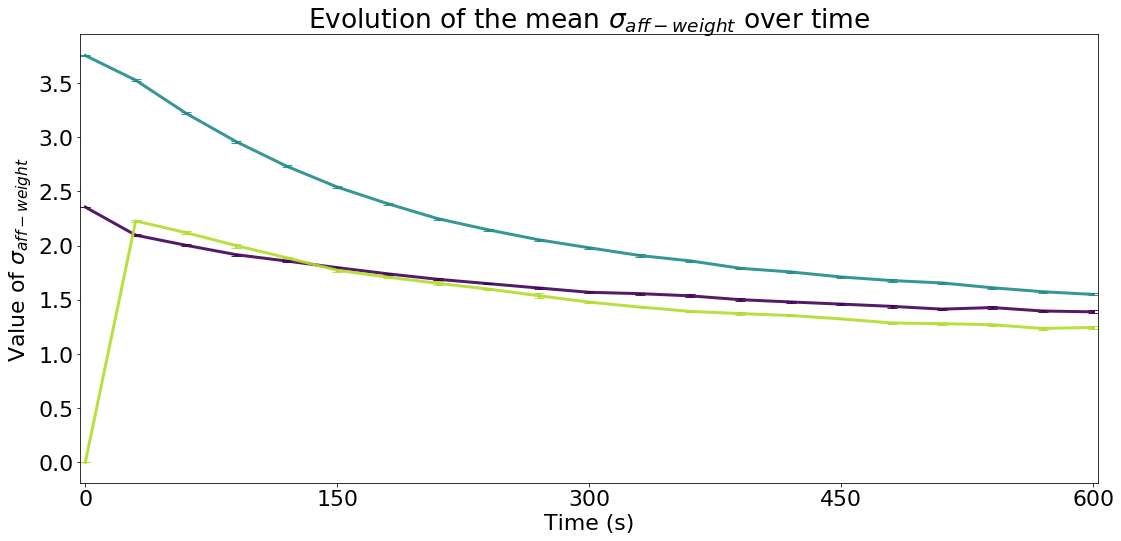

In [20]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8), dpi=600)
# conc_std_1 = np.concatenate(([hardcoded_init_mean_std], np.mean(all_mean_sigmas_case_1, axis=0)))
# conc_std_2 = np.concatenate(([hardcoded_init_mean_std], np.mean(all_mean_sigmas_case_2, axis=0)))
# conc_std_3 = np.concatenate(([hardcoded_init_mean_std], np.mean(all_mean_sigmas_case_3, axis=0)))

# conc_std_1_std = np.concatenate(([0], stats.sem(all_mean_sigmas_case_1, axis=0)))
# conc_std_2_std = np.concatenate(([0], stats.sem(all_mean_sigmas_case_2, axis=0)))
# conc_std_3_std = np.concatenate(([0], stats.sem(all_mean_sigmas_case_3, axis=0)))


# i = \
# ax1.errorbar(np.arange(conc_std_1.size) * hardcoded_t_record, conc_std_1, conc_std_1_std, label='Mean $\sigma_{aff\_weight}$ case 1', alpha=.9, linewidth=3)
# ax1.errorbar(np.arange(conc_std_2.size) * hardcoded_t_record, conc_std_2, conc_std_2_std, label='Mean $\sigma_{aff\_weight}$ case 2', alpha=.7, linewidth=3)
# ax1.errorbar(np.arange(conc_std_3.size) * hardcoded_t_record, conc_std_3, conc_std_3_std, label='Mean $\sigma_{aff\_weight}$ case 3', alpha=.7, linewidth=3)
# ax1.plot(np.arange(all_mean_sigmas_case_3.size+1) * hardcoded_t_record, conc_case_3, label='Mean $\sigma_{aff}$ case 3 lesioned Gaussian input', alpha=.7, linewidth=2, ls='--')
# ax1.plot(np.arange(all_mean_sigmas_case_1_gaussian_input.size+1) * hardcoded_t_record, conc_case_1_gaussian_input, label='Mean $\sigma_{aff}$ case 1 non-lesioned Gaussian input', alpha=.7, linewidth=2, ls=':', c='k' )
# ax1.plot(np.arange(all_mean_sigmas_case_1_lesioned_gaussian_input.size+1) * hardcoded_t_record, conc_case_1_gaussian_input_lesioned, label='Mean $\sigma_{aff}$ case 1 lesioned Gaussian input', alpha=.7, linewidth=2, ls='--',c='b' )
lesion_text = ["Topographic",  "Random", "None"]
for case in parameters_of_interest['cases']:
#     for input_type, input_colour in zip(parameters_of_interest['input_types'], ['#3E0A4F', '#366488', '#4EC373', '#f3e718']):
    for lesion_type, lesion_colour in zip(parameters_of_interest['lesion_types'],['#440357', '#228b8d', '#b2dd2c']): 
        all_stats = generate_snapshot_statistics(get_id_of_params(lesion_type=lesion_type, case=case))
#             print all_stats
#             break
#         l = '{}'.format(lesion_text[lesion_type])
#         labels.append(l)
        _ = ax1.errorbar(np.arange(len(all_stats[0])) * hardcoded_t_record, all_stats[0], all_stats[1], 
                         label='$\sigma_{aff\_weight}$ ' + '{}'.format(lesion_text[lesion_type]),  
                         alpha=.9, linewidth=3,
                        color=lesion_colour) #, color=input_colour)


ax1.grid(visible=False)
ax1.set_title("Evolution of the mean $\sigma_{aff-weight}$ over time")
# ax1.set_ylim([0, np.max([conc_std_1, conc_std_2, conc_std_3]) + 0.2])
ax1.set_xlabel("Time (" + str(hardcoded_t_record.dimensions) + ")")
ax1.set_ylabel("Value of $\sigma_{aff-weight}$")

# ax1.scatter(0, hardcoded_init_mean_std, marker='x', c='r', label="Initial mean $\sigma_{aff}$ in the original, non-lesioned case")
# ax1.scatter(conc_std_1.size* hardcoded_t_record//2, 1.42, c='r', label="Final mean $\sigma_{aff}$ in the original, non-lesioned case")
# ax1.set_ylim([0, 4.0])
# ax1.set_xlim([-1, 301])
# ax1.set_yscale("symlog", linthreshy=.0001)

# ax1.set_xticks([20, 200, 500])
# ax1.get_yaxis().set_major_formatter(mlib.ticker.ScalarFormatter())

# lspace = np.linspace(0.1, 1.5, 10)

# ax1.set_yticks(lspace)
# lspacelabels = []
# for value in lspace:
#     lspacelabels.append("{:1.1f}".format(value))
# ax1.set_yticklabels(lspacelabels)

ax1.set_xticks([0, 150, 300, 450, 600])
ax1.set_xlim([-3, 603])

# ax1.legend(loc='upper right')
plt.tight_layout()
plt.savefig("case_3_std_evo.png")
plt.show()

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:34: RuntimeWarning: divide by zero encountered in log
 [py.warnings]

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:35: RuntimeWarning: divide by zero encountered in log
 [py.warnings]

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:36: RuntimeWarning: divide by zero encountered in log
 [py.warnings]

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:37: RuntimeWarning: divide by zero encountered in log
 [py.warnings]



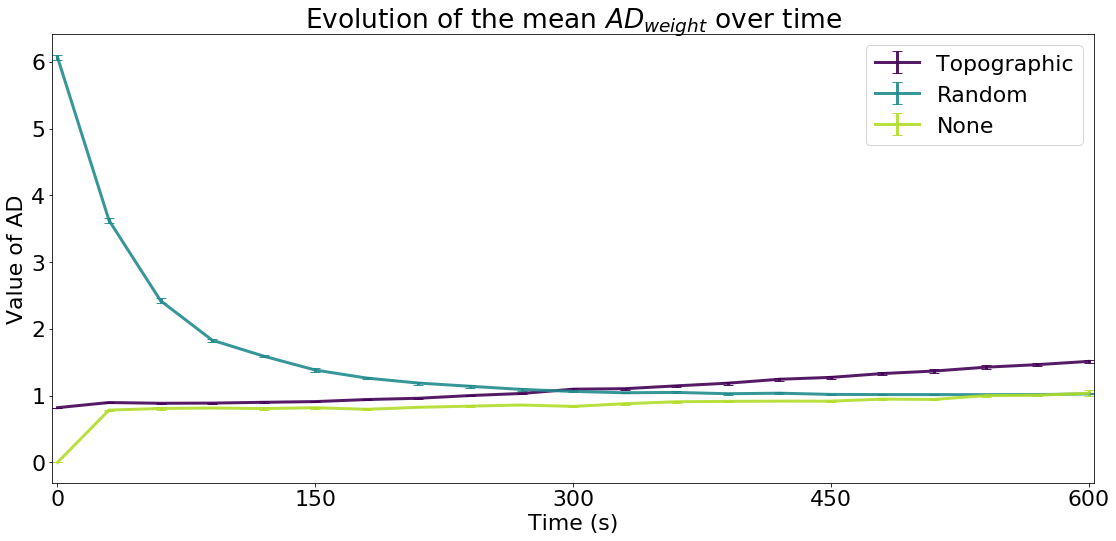

In [19]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(16, 8), dpi=600)
# conc_std_1 = np.concatenate(([hardcoded_init_mean_std], np.mean(all_mean_sigmas_case_1, axis=0)))
# conc_std_2 = np.concatenate(([hardcoded_init_mean_std], np.mean(all_mean_sigmas_case_2, axis=0)))
# conc_std_3 = np.concatenate(([hardcoded_init_mean_std], np.mean(all_mean_sigmas_case_3, axis=0)))

# conc_std_1_std = np.concatenate(([0], stats.sem(all_mean_sigmas_case_1, axis=0)))
# conc_std_2_std = np.concatenate(([0], stats.sem(all_mean_sigmas_case_2, axis=0)))
# conc_std_3_std = np.concatenate(([0], stats.sem(all_mean_sigmas_case_3, axis=0)))


# i = \
# ax1.errorbar(np.arange(conc_std_1.size) * hardcoded_t_record, conc_std_1, conc_std_1_std, label='Mean $\sigma_{aff\_weight}$ case 1', alpha=.9, linewidth=3)
# ax1.errorbar(np.arange(conc_std_2.size) * hardcoded_t_record, conc_std_2, conc_std_2_std, label='Mean $\sigma_{aff\_weight}$ case 2', alpha=.7, linewidth=3)
# ax1.errorbar(np.arange(conc_std_3.size) * hardcoded_t_record, conc_std_3, conc_std_3_std, label='Mean $\sigma_{aff\_weight}$ case 3', alpha=.7, linewidth=3)
# ax1.plot(np.arange(all_mean_sigmas_case_3.size+1) * hardcoded_t_record, conc_case_3, label='Mean $\sigma_{aff}$ case 3 lesioned Gaussian input', alpha=.7, linewidth=2, ls='--')
# ax1.plot(np.arange(all_mean_sigmas_case_1_gaussian_input.size+1) * hardcoded_t_record, conc_case_1_gaussian_input, label='Mean $\sigma_{aff}$ case 1 non-lesioned Gaussian input', alpha=.7, linewidth=2, ls=':', c='k' )
# ax1.plot(np.arange(all_mean_sigmas_case_1_lesioned_gaussian_input.size+1) * hardcoded_t_record, conc_case_1_gaussian_input_lesioned, label='Mean $\sigma_{aff}$ case 1 lesioned Gaussian input', alpha=.7, linewidth=2, ls='--',c='b' )

lines = []
labels= []

input_text = ["Gaussian", "Pointy", "Scaled Pointy", "Square"]
lesion_text = ["Topographic",  "Random", "None"]

for case in parameters_of_interest['cases']:
#     for input_type, input_colour in zip(parameters_of_interest['input_types'], ['#3E0A4F', '#366488', '#4EC373', '#f3e718']):
    for lesion_type, lesion_colour in zip(parameters_of_interest['lesion_types'],['#440357', '#228b8d', '#b2dd2c']): 
        all_stats = generate_snapshot_statistics(get_id_of_params(lesion_type=lesion_type, case=case))
        l = '{}'.format(lesion_text[lesion_type])
        labels.append(l)
        
        lines.append(ax1.errorbar(np.arange(len(all_stats[2])) * hardcoded_t_record, all_stats[2], all_stats[3], 
                         label=l, 
                         alpha=.9, linewidth=3,
                        color=lesion_colour ) #, color=input_colour)
                     )
            


ax1.grid(visible=False)
ax1.set_title("Evolution of the mean $AD_{weight}$ over time")
# ax1.set_ylim([0, np.max([conc_std_1, conc_std_2, conc_std_3]) + 0.2])
ax1.set_xlabel("Time (" + str(hardcoded_t_record.dimensions) + ")")
ax1.set_ylabel("Value of AD")


# ax1.set_yscale("log")
# ax1.set_xticks([20, 200, 500])
# ax1.get_yaxis().set_major_formatter(mlib.ticker.ScalarFormatter())
# ax1.set_yticks(np.arange(1,7))

ax1.set_xticks([0, 150, 300, 450, 600])
ax1.set_xlim([-3, 603])
# ax1.scatter(0, hardcoded_init_mean_std, marker='x', c='r', label="Initial mean $\sigma_{aff}$ in the original, non-lesioned case")
# ax1.scatter(conc_std_1.size* hardcoded_t_record//2, 1.42, c='r', label="Final mean $\sigma_{aff}$ in the original, non-lesioned case")
# ax1.set_ylim([0.5, 3.5])
# ax1.set_xlim([-1, 301])
ax1.legend(loc='best')
# f.legend(lines,l, loc='right', ncol=2)
plt.tight_layout()
plt.savefig("case_3_ad_evo.png")
plt.show()

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:34: RuntimeWarning: divide by zero encountered in log
 [py.warnings]

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:35: RuntimeWarning: divide by zero encountered in log
 [py.warnings]

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:36: RuntimeWarning: divide by zero encountered in log
 [py.warnings]

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:37: RuntimeWarning: divide by zero encountered in log
 [py.warnings]



1.51330576576 0.0269665055939
1.02643074865 0.00917830236074
1.03574083799 0.0419331265387


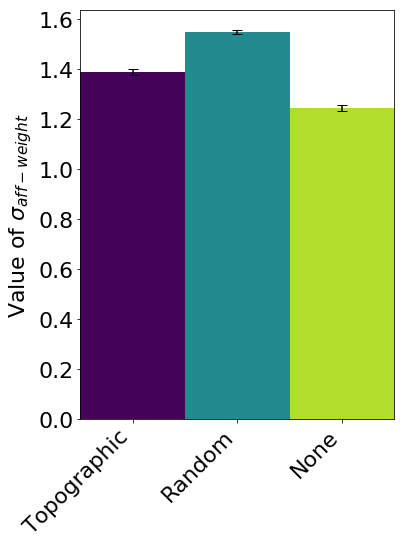

In [17]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(6, 8), dpi=600)  
# (len(sigma_stims), len(lesion_types), len(input_types)
lesion_text = ["Topographic",  "Random", "None"]
colours = ['#440357', '#228b8d','#b2dd2c']
for lesion_type, lesion_ls, offset, lesion_colour in zip(parameters_of_interest['lesion_types'],lesion_text, [0, 1, 2], colours): 
    all_stats = generate_snapshot_statistics(get_id_of_params(lesion_type=lesion_type, case=case))
    l = '{}'.format(lesion_text[lesion_type])
    print all_stats[2][ -1], all_stats[3][ -1]
    ax1.bar(offset, all_stats[0][ -1], width=1, yerr=all_stats[1][ -1],linewidth=3, label=lesion_ls, color=lesion_colour)
#         lines.append(ax1.errorbar(np.arange(len(all_stats[2])) * hardcoded_t_record, all_stats[2], all_stats[3], 
#                          label=l, 
#                          alpha=.9, linewidth=3,
#                         linestyle=lesion_ls ) #, color=input_colour)
#                      )


ax1.grid(visible=False)
# ax1.set_title("Evolution of the mean $\sigma_{aff-weight}$ over time")
# ax1.set_xlabel("Type of initial connectivity")
ax1.set_ylabel("Value of $\sigma_{aff-weight}$")


ax1.set_xticks(range(len(lesion_text)))
ax1.set_xticklabels(lesion_text, rotation=45, horizontalalignment='right')



ax1.set_xlim([-.5, 2.5])
# ax1.legend(loc='best')

# ax1.legend(loc='best')
plt.tight_layout()
plt.savefig("case_3_std_barchart.png")
# plt.savefig("final_mean_ad_stderr_bar_lesion_types.eps")
plt.show()

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:34: RuntimeWarning: divide by zero encountered in log
 [py.warnings]

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:35: RuntimeWarning: divide by zero encountered in log
 [py.warnings]

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:36: RuntimeWarning: divide by zero encountered in log
 [py.warnings]

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:37: RuntimeWarning: divide by zero encountered in log
 [py.warnings]



1.51330576576 0.0269665055939
1.02643074865 0.00917830236074
1.03574083799 0.0419331265387


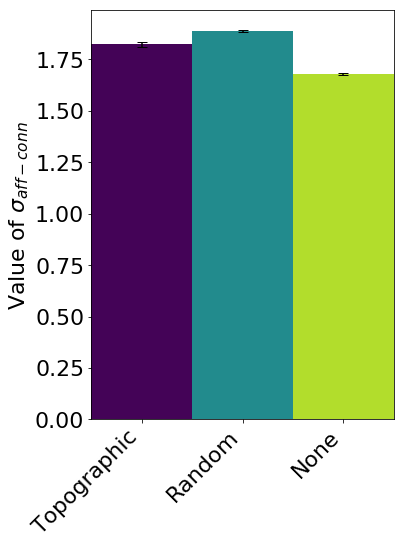

In [21]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(6, 8), dpi=600)  
# (len(sigma_stims), len(lesion_types), len(input_types)
lesion_text = ["Topographic",  "Random", "None"]
colours = ['#440357', '#228b8d','#b2dd2c']
for lesion_type, lesion_ls, offset, lesion_colour in zip(parameters_of_interest['lesion_types'],lesion_text, [0, 1, 2], colours): 
    all_stats = generate_snapshot_statistics(get_id_of_params(lesion_type=lesion_type, case=case))
    l = '{}'.format(lesion_text[lesion_type])
    print all_stats[2][ -1], all_stats[3][ -1]
    ax1.bar(offset, all_stats[4][ -1], width=1, yerr=all_stats[5][ -1],linewidth=3, label=lesion_ls, color=lesion_colour)
#         lines.append(ax1.errorbar(np.arange(len(all_stats[2])) * hardcoded_t_record, all_stats[2], all_stats[3], 
#                          label=l, 
#                          alpha=.9, linewidth=3,
#                         linestyle=lesion_ls ) #, color=input_colour)
#                      )


ax1.grid(visible=False)
# ax1.set_title("Evolution of the mean $\sigma_{aff-weight}$ over time")
# ax1.set_xlabel("Type of initial connectivity")
ax1.set_ylabel("Value of $\sigma_{aff-conn}$")


ax1.set_xticks(range(len(lesion_text)))
ax1.set_xticklabels(lesion_text, rotation=45, horizontalalignment='right')



ax1.set_xlim([-.5, 2.5])
# ax1.legend(loc='best')

# ax1.legend(loc='best')
plt.tight_layout()
plt.savefig("case_3_std_conn_barchart.png")
# plt.savefig("final_mean_ad_stderr_bar_lesion_types.eps")
plt.show()

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:34: RuntimeWarning: divide by zero encountered in log
 [py.warnings]

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:35: RuntimeWarning: divide by zero encountered in log
 [py.warnings]

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:36: RuntimeWarning: divide by zero encountered in log
 [py.warnings]

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:37: RuntimeWarning: divide by zero encountered in log
 [py.warnings]



1.51330576576 0.0269665055939
1.02643074865 0.00917830236074
1.03574083799 0.0419331265387


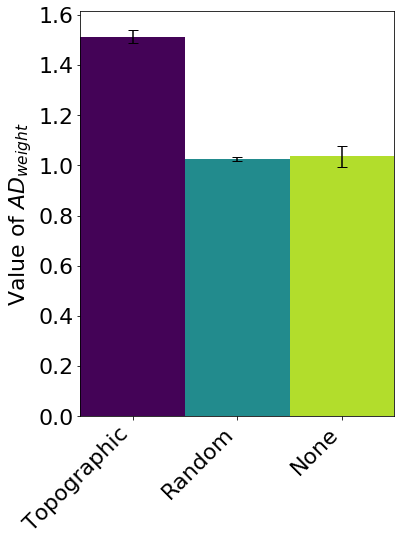

In [18]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(6, 8), dpi=600)  
# (len(sigma_stims), len(lesion_types), len(input_types)
lesion_text = ["Topographic",  "Random", "None"]
for lesion_type, lesion_ls, offset, lesion_colour in zip(parameters_of_interest['lesion_types'],lesion_text, [0, 1, 2], colours): 
    all_stats = generate_snapshot_statistics(get_id_of_params(lesion_type=lesion_type, case=case))
    l = '{}'.format(lesion_text[lesion_type])
    print all_stats[2][ -1], all_stats[3][ -1]
    ax1.bar(offset, all_stats[2][ -1], width=1, yerr=all_stats[3][ -1],linewidth=3, label=lesion_ls, color=lesion_colour)

ax1.grid(visible=False)
# ax1.set_title("Evolution of the mean $\sigma_{aff-weight}$ over time")
# ax1.set_xlabel("Type of initial connectivity")
ax1.set_ylabel("Value of $AD_{weight}$")


ax1.set_xticks(range(len(lesion_text)))
ax1.set_xticklabels(lesion_text, rotation=45, horizontalalignment='right')



# ax1.set_ylim([0, 3.0])
# ax1.legend(loc='best')
ax1.set_xlim([-.5, 2.5])
# ax1.legend(loc='best')
plt.tight_layout()
plt.savefig("case_3_ad_barchart.png", dpi=600)
# plt.savefig("final_mean_ad_stderr_bar_lesion_types.eps")
plt.show()

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:34: RuntimeWarning: divide by zero encountered in log
 [py.warnings]

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:35: RuntimeWarning: divide by zero encountered in log
 [py.warnings]

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:36: RuntimeWarning: divide by zero encountered in log
 [py.warnings]

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:37: RuntimeWarning: divide by zero encountered in log
 [py.warnings]



1.51330576576 0.0269665055939
1.02643074865 0.00917830236074
1.03574083799 0.0419331265387


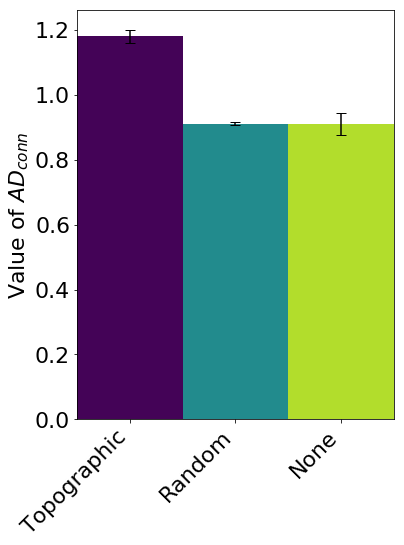

In [22]:
f, (ax1) = plt.subplots(1, 1 ,figsize=(6, 8), dpi=600)  
# (len(sigma_stims), len(lesion_types), len(input_types)
lesion_text = ["Topographic",  "Random", "None"]
for lesion_type, lesion_ls, offset, lesion_colour in zip(parameters_of_interest['lesion_types'],lesion_text, [0, 1, 2], colours): 
    all_stats = generate_snapshot_statistics(get_id_of_params(lesion_type=lesion_type, case=case))
    l = '{}'.format(lesion_text[lesion_type])
    print all_stats[2][ -1], all_stats[3][ -1]
    ax1.bar(offset, all_stats[6][ -1], width=1, yerr=all_stats[7][ -1],linewidth=3, label=lesion_ls, color=lesion_colour)

ax1.grid(visible=False)
# ax1.set_title("Evolution of the mean $\sigma_{aff-weight}$ over time")
# ax1.set_xlabel("Type of initial connectivity")
ax1.set_ylabel("Value of $AD_{conn}$")


ax1.set_xticks(range(len(lesion_text)))
ax1.set_xticklabels(lesion_text, rotation=45, horizontalalignment='right')



# ax1.set_ylim([0, 3.0])
# ax1.legend(loc='best')
ax1.set_xlim([-.5, 2.5])
# ax1.legend(loc='best')
plt.tight_layout()
plt.savefig("case_3_ad_conn_barchart.png", dpi=600)
# plt.savefig("final_mean_ad_stderr_bar_lesion_types.eps")
plt.show()

In [14]:
np.log(all_stats[2])

WARNING    C:\WinPython-64bit-2.7.9.4\python-2.7.9.amd64\lib\site-packages\IPython\kernel\__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
 [py.warnings]
  if __name__ == '__main__':



array([       -inf, -0.24397359, -0.21296135, -0.20436088, -0.21463774,
       -0.1997748 , -0.22873981, -0.19186922, -0.17111299, -0.15104986,
       -0.17572008, -0.12865662, -0.09603553, -0.0892297 , -0.08582393,
       -0.08597243, -0.05353309, -0.05833897,  0.00032526,  0.00679177,
        0.03511696])

# Let's report some average numbers

In [150]:
rates_case_1 = results[0:10, 0]
rates_case_2 = results[10:20, 0]
rates_case_3 = results[20:30, 0]

final_number_of_syn_case_1 = results[0:10, 1]
final_number_of_syn_case_2 = results[10:20, 1]
final_number_of_syn_case_3 = results[20:30, 1]

weight_proportion_case_1 = results[0:10, 2]
weight_proportion_case_2 = results[10:20, 2]
weight_proportion_case_3 = results[20:30, 2]

p_sigma_aff_conn_case_1 = results[0:10, 6]
p_sigma_aff_conn_case_2 = results[10:20, 6]
p_sigma_aff_conn_case_3 = results[20:30, 6]

p_sigma_aff_weight_case_1 = results[0:10, 9]
p_sigma_aff_weight_case_2 = results[10:20, 9]
p_sigma_aff_weight_case_3 = results[20:30, 9]

p_ad_conn_case_1 = results[0:10, 13]
p_ad_conn_case_2 = results[10:20, 13]
p_ad_conn_case_3 = results[20:30, 13]

p_ad_weight_case_1 = results[0:10, 16]
p_ad_weight_case_2 = results[10:20, 16]
p_ad_weight_case_3 = results[20:30, 16]

In [143]:
print "rates"
print np.mean(rates_case_1), stats.scoreatpercentile(rates_case_1, 95)
print np.mean(rates_case_2), stats.scoreatpercentile(rates_case_2, 95)
print np.mean(rates_case_3), stats.scoreatpercentile(rates_case_3, 95) 

rates
21.1355716146 21.2310944011
20.0807877604 20.1449492187
9.37506640625 9.48626171875


In [149]:
print "final_number_of_syn"
print np.mean(final_number_of_syn_case_1), stats.scoreatpercentile(final_number_of_syn_case_1, 95)
print np.mean(final_number_of_syn_case_2), stats.scoreatpercentile(final_number_of_syn_case_2, 95)
print np.mean(final_number_of_syn_case_3), stats.scoreatpercentile(final_number_of_syn_case_3, 95) 

final_number_of_syn
15.8015625 15.9845703125
16.0 16.0
11.897265625 12.05234375


In [151]:
print "weight_proportion"
print np.mean(weight_proportion_case_1), stats.scoreatpercentile(weight_proportion_case_1, 95)
print np.mean(weight_proportion_case_2), stats.scoreatpercentile(weight_proportion_case_2, 95)
print np.mean(weight_proportion_case_3), stats.scoreatpercentile(weight_proportion_case_3, 95) 

weight_proportion
0.828067183224 0.838854271955
0.709332168102 0.723161369562
0.607832549803 0.622256648146


In [144]:
print "p_ad_conn"
print np.mean(p_ad_conn_case_1<0.05) * 100, "%" , stats.scoreatpercentile(p_ad_conn_case_1, 95)
print np.mean(p_ad_conn_case_2<0.05) * 100, "%" , stats.scoreatpercentile(p_ad_conn_case_2, 95)
print np.mean(p_ad_conn_case_3<0.05) * 100, "%" , stats.scoreatpercentile(p_ad_conn_case_3, 95)

p_ad_conn
10.0 % 0.480281685054
0.0 % 0.85085102503
0.0 % 0.69163492977


In [145]:
print "p_ad_weight"
print np.mean(p_ad_weight_case_1<0.05) * 100, "%" , stats.scoreatpercentile(p_ad_weight_case_1, 95)
print np.mean(p_ad_weight_case_2<0.05) * 100, "%" , stats.scoreatpercentile(p_ad_weight_case_2, 95)
print np.mean(p_ad_weight_case_3<0.05) * 100, "%" , stats.scoreatpercentile(p_ad_weight_case_3, 95)

p_ad_weight
50.0 % 0.586598678511
70.0 % 0.189788101393
10.0 % 0.849346251479


In [147]:
print "p_sigma_aff_conn"
print np.mean(p_sigma_aff_conn_case_1<0.05) * 100, "%" , stats.scoreatpercentile(p_sigma_aff_conn_case_1, 95)
print np.mean(p_sigma_aff_conn_case_2<0.05) * 100, "%" , stats.scoreatpercentile(p_sigma_aff_conn_case_2, 95)
print np.mean(p_sigma_aff_conn_case_3<0.05) * 100, "%" , stats.scoreatpercentile(p_sigma_aff_conn_case_3, 95)

p_sigma_aff_conn
100.0 % 4.24289202912e-42
0.0 % 0.989538257019
100.0 % 6.52508403983e-15


In [148]:
print "p_sigma_aff_weight"
print np.mean(p_sigma_aff_weight_case_1<0.05) * 100, "%" , stats.scoreatpercentile(p_sigma_aff_weight_case_1, 95)
print np.mean(p_sigma_aff_weight_case_2<0.05) * 100, "%" , stats.scoreatpercentile(p_sigma_aff_weight_case_2, 95)
print np.mean(p_sigma_aff_weight_case_3<0.05) * 100, "%" , stats.scoreatpercentile(p_sigma_aff_weight_case_3, 95)

p_sigma_aff_weight
100.0 % 1.97177599148e-32
100.0 % 2.86099086389e-43
100.0 % 2.18620835771e-17
